In [4]:
import math
import numpy as np
import torch
import torchvision
import transformers

device = torch.device("cuda")

#image_processor = transformers.AutoImageProcessor.from_pretrained("microsoft/resnet-50")
image_processor = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    #lambda x: x / 255,
])
model = transformers.ResNetModel.from_pretrained("microsoft/resnet-50").to(device)

(255, 198)


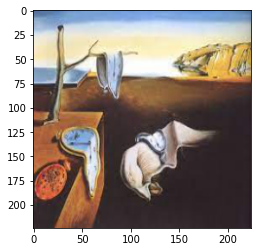

torch.Size([1, 3, 224, 224])
torch.Size([1, 64, 56, 56])
tensor(90005.2109, device='cuda:0')
tensor(2640351.5000, device='cuda:0')

torch.Size([1, 256, 56, 56])
tensor(72242.7422, device='cuda:0')
tensor(5754.4253, device='cuda:0')

torch.Size([1, 512, 28, 28])
tensor(807119., device='cuda:0')
tensor(808570.6875, device='cuda:0')

torch.Size([1, 1024, 14, 14])
tensor(318789.5000, device='cuda:0')
tensor(94910.4922, device='cuda:0')

torch.Size([1, 2048, 7, 7])
tensor(11003.2236, device='cuda:0')
tensor(205.5191, device='cuda:0')



In [5]:
import matplotlib.pyplot as plt
import PIL

def content_loss(a, b):
    diff2 = (a - b)
    diff2 = diff2 * diff2
    return torch.sum(diff2) / 2

def gram(layer):
    shape = layer.shape
    features = layer.reshape((shape[0], shape[1], shape[2] * shape[3]))
    g = torch.matmul(features, features.transpose(1, 2))
    return g

def style_loss(a, b):
    a_gram, b_gram = gram(a), gram(b)
    diff2 = (a_gram - b_gram)
    diff2 = diff2 * diff2
    return torch.sum(diff2) / 2 / a.shape[1] / a.shape[2] / a.shape[3]

dog = PIL.Image.open('dog6.jpeg')
#print(np.asarray(dog))
time = PIL.Image.open('time2.jpeg')
#dog.show()
print(dog.size)

dog_inputs = image_processor(dog).unsqueeze(0).to(device)
#print(dog_inputs)
#print(torch.min(dog_inputs))
time_inputs = image_processor(time).unsqueeze(0).to(device)
plt.imshow(time_inputs.squeeze(0).permute(1, 2, 0).cpu().detach().numpy())
plt.show()
print(dog_inputs.shape)
with torch.no_grad():
    dog_outputs = model(dog_inputs, output_hidden_states = True)
    time_outputs = model(time_inputs, output_hidden_states = True)

for dog_state, time_state in zip(dog_outputs.hidden_states, time_outputs.hidden_states):
    print(dog_state.shape)
    print(content_loss(dog_state, time_state))
    print(style_loss(dog_state, time_state))
    print("")    

In [6]:
for name, param in model.named_parameters():
    print(name)
    param.requires_grad = False

embedder.embedder.convolution.weight
embedder.embedder.normalization.weight
embedder.embedder.normalization.bias
encoder.stages.0.layers.0.shortcut.convolution.weight
encoder.stages.0.layers.0.shortcut.normalization.weight
encoder.stages.0.layers.0.shortcut.normalization.bias
encoder.stages.0.layers.0.layer.0.convolution.weight
encoder.stages.0.layers.0.layer.0.normalization.weight
encoder.stages.0.layers.0.layer.0.normalization.bias
encoder.stages.0.layers.0.layer.1.convolution.weight
encoder.stages.0.layers.0.layer.1.normalization.weight
encoder.stages.0.layers.0.layer.1.normalization.bias
encoder.stages.0.layers.0.layer.2.convolution.weight
encoder.stages.0.layers.0.layer.2.normalization.weight
encoder.stages.0.layers.0.layer.2.normalization.bias
encoder.stages.0.layers.1.layer.0.convolution.weight
encoder.stages.0.layers.1.layer.0.normalization.weight
encoder.stages.0.layers.1.layer.0.normalization.bias
encoder.stages.0.layers.1.layer.1.convolution.weight
encoder.stages.0.layers.1.

In [7]:
def apply_style_transfer(content_path, style_path, iterations, checkpoints):
    content_target = PIL.Image.open(content_path)
    style_target = PIL.Image.open(style_path)

    img = torch.tensor(image_processor(content_target).unsqueeze(0), requires_grad=True, device=device)
    #img = torch.rand((1, 3, 224, 224), requires_grad=True, device=device)
    print(img.shape)

    with torch.no_grad():
        content_inputs = image_processor(content_target).unsqueeze(0).to(device)
        style_inputs = image_processor(style_target).unsqueeze(0).to(device)
        content_outputs = model(content_inputs, output_hidden_states = True)
        style_outputs = model(style_inputs, output_hidden_states = True)

    optimiser = torch.optim.Adam([img], lr = 1e-3, eps = 1e-12)
    for i in range(iterations + 1):
        optimiser.zero_grad()
        img_outputs = model(img, output_hidden_states = True)
        loss = (
            #content_loss(img_outputs.hidden_states[0], content_outputs.hidden_states[0])+
            #content_loss(img_outputs.hidden_states[1], content_outputs.hidden_states[1])
            #content_loss(img_outputs.hidden_states[2], content_outputs.hidden_states[2])+
            content_loss(img_outputs.hidden_states[3], content_outputs.hidden_states[3])+
            content_loss(img_outputs.hidden_states[4], content_outputs.hidden_states[4])
        ) / 2 + (
            style_loss(img_outputs.hidden_states[0], style_outputs.hidden_states[0])+
            style_loss(img_outputs.hidden_states[1], style_outputs.hidden_states[1])+
            style_loss(img_outputs.hidden_states[2], style_outputs.hidden_states[2])+
            style_loss(img_outputs.hidden_states[3], style_outputs.hidden_states[3])+
            style_loss(img_outputs.hidden_states[4], style_outputs.hidden_states[4])
        ) / 5 * 10000
        if i % checkpoints == 0:
            print(loss.item())
            plt.imshow(img.squeeze(0).permute(1, 2, 0).cpu().detach().numpy())
            plt.show()
        loss.backward()
        optimiser.step()

torch.Size([1, 3, 224, 224])
9304423424.0


<ipython-input-7-b2da19d1d52f>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(image_processor(content_target).unsqueeze(0), requires_grad=True, device=device)


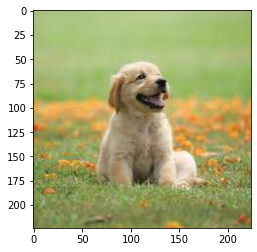

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


75087248.0


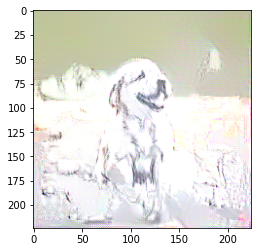

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


25044086.0


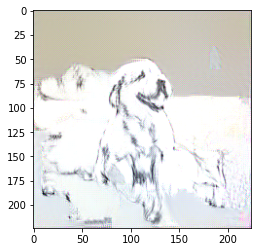

In [8]:
apply_style_transfer("dog.jpeg", "dog_sketch.jpeg", 5000, 2500)

torch.Size([1, 3, 224, 224])
7656112640.0


<ipython-input-4-467c97eeb6e0>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(image_processor(content_target).unsqueeze(0), requires_grad=True, device=device)


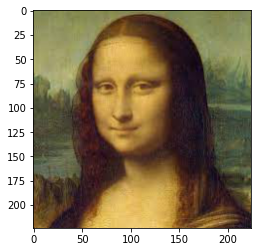

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5775308.5


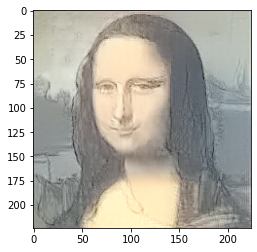

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2184083.5


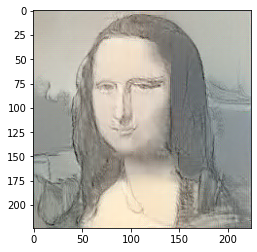

In [7]:
apply_style_transfer("mona_lisa.jpeg", "dog9.jpeg", 5000, 2500)

torch.Size([1, 3, 224, 224])
2214663680.0


<ipython-input-4-467c97eeb6e0>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(image_processor(content_target).unsqueeze(0), requires_grad=True, device=device)


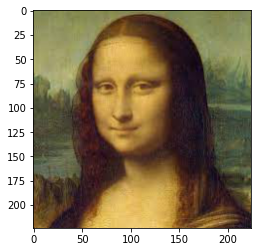

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9758655.0


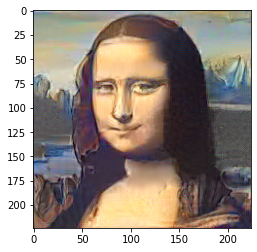

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4734253.0


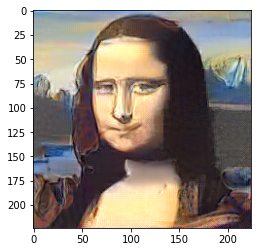

In [9]:
apply_style_transfer("mona_lisa.jpeg", "time2.jpeg", 5000, 2500)

torch.Size([1, 3, 224, 224])
5951272448.0


<ipython-input-4-467c97eeb6e0>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(image_processor(content_target).unsqueeze(0), requires_grad=True, device=device)


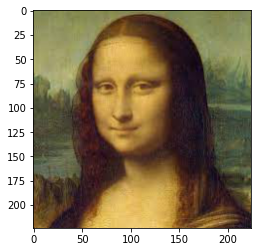

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


18777192.0


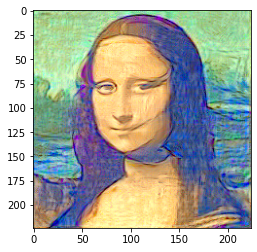

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6563009.5


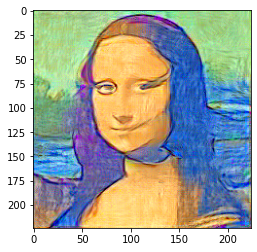

In [10]:
apply_style_transfer("mona_lisa.jpeg", "picasso.jpeg", 5000, 2500)

torch.Size([1, 3, 224, 224])
28071137280.0


<ipython-input-4-467c97eeb6e0>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(image_processor(content_target).unsqueeze(0), requires_grad=True, device=device)


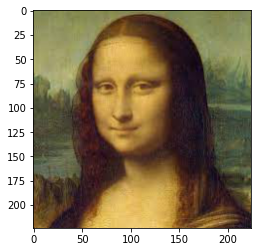

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


228087776.0


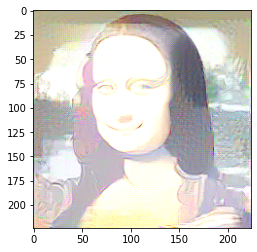

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


98195432.0


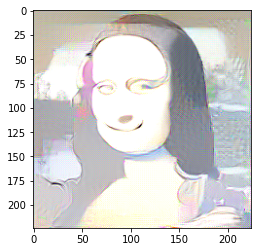

In [11]:
apply_style_transfer("mona_lisa.jpeg", "mouse.jpeg", 5000, 2500)

torch.Size([1, 3, 224, 224])
831488256.0


<ipython-input-4-467c97eeb6e0>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(image_processor(content_target).unsqueeze(0), requires_grad=True, device=device)


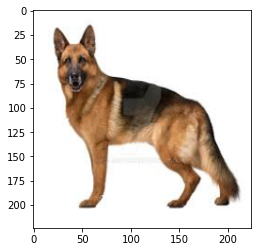

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


13631101.0


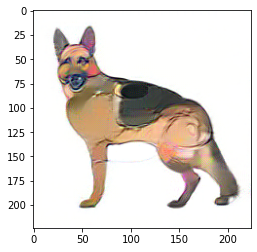

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8514959.0


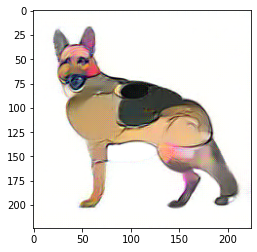

In [12]:
apply_style_transfer("dog10.jpeg", "mouse.jpeg", 5000, 2500)

torch.Size([1, 3, 224, 224])
8818405376.0


<ipython-input-4-467c97eeb6e0>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(image_processor(content_target).unsqueeze(0), requires_grad=True, device=device)


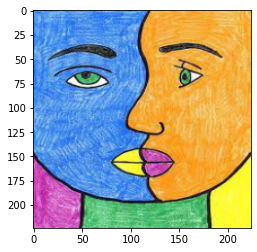

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


130997000.0


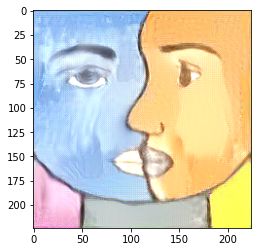

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


46271376.0


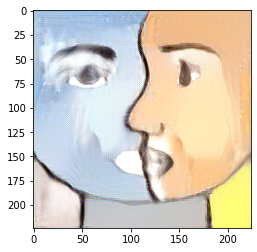

In [14]:
apply_style_transfer("picasso.jpeg", "dog10.jpeg", 5000, 2500)